<a href="https://colab.research.google.com/github/musicjae/GNN/blob/main/1%20DGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

원문: https://github.com/emergx/gnn-tutorials/blob/master/1_first.ipynb

# "Zachary's karate club" problem  
  

- The karate club is a social network that includes 34 members and documents pairwise links between members who interact outside the club  
  
-  The club later divides into two communities led by the instructor (node 0) and the club president (node 33). The network is visualized as follows with the color indicating the community:
  
** DGL is a Python package dedicated to deep learning on graphs **



In [1]:
!pip install dgl

     |████████████████████████████████| 3.6MB 5.9MB/s 


In [7]:
!pip install networkx

In [35]:
import dgl
import numpy as np
import networkx as nx
from dgl.nn.pytorch import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])

    u = np.concatenate([src,dst])
    v = np.concatenate([dst,src])  # Edges are directional in DGL; Make them bi-directional

    return dgl.DGLGraph((u,v))

## 1 그래프 그리기

In [36]:
G = build_karate_club_graph()
print('node의 개수: %d ' % G.number_of_nodes())
print('edge의 개수: %d ' % G.number_of_edges())

node의 개수: 34 
edge의 개수: 156 


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


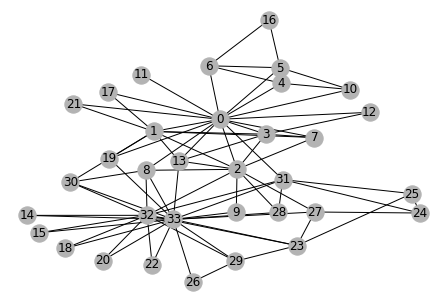

In [37]:
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G) # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
nx.draw(nx_G, pos, with_labels=True,node_color=[[.7,.7,.7]])

## feature를 node,edge에 할당하기

In [24]:
embed = nn.Embedding(34,5) # 34개 노드, 차원 5
G.ndata['feat'] = embed.weight
print(G.ndata['feat'])

Parameter containing:
tensor([[ 1.2252, -0.5357,  0.5400, -1.7511, -0.3820],
        [-0.5719, -1.4921,  0.9219, -2.7477,  0.1176],
        [-1.3174,  0.8239, -0.9469,  0.0779, -1.1225],
        [-0.4249, -0.8298,  0.8837,  0.9064,  0.9068],
        [-0.4926, -0.9753, -1.1089, -1.0749,  1.4789],
        [ 0.2340,  0.4026, -0.6745,  0.4983,  0.2620],
        [-0.0182, -0.7767, -0.2475,  0.4809, -0.8742],
        [ 0.7547, -0.3425,  0.4605, -1.1367,  0.8909],
        [ 0.1075, -1.3220, -1.4807,  0.0805,  1.2937],
        [-2.7964, -0.0114,  1.0083, -1.0395, -2.1801],
        [-0.1690,  0.5040, -0.8046, -0.5969, -0.1984],
        [ 2.0612,  0.4798,  0.7732, -0.6318, -0.5859],
        [-1.5725,  0.1333,  0.1380,  0.9889, -0.6241],
        [ 0.6639, -0.5703, -1.1963, -1.2054,  0.9751],
        [ 0.0885, -0.4036, -0.9165,  0.5254,  1.6755],
        [ 0.7355, -0.1002,  0.4033, -1.1966,  0.1900],
        [-0.5836,  0.8500,  1.9195,  0.3113, -0.1413],
        [ 1.5448,  0.5449,  0.3355,  0.9876

In [25]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([-1.3174,  0.8239, -0.9469,  0.0779, -1.1225], grad_fn=<SelectBackward>)
tensor([[-0.1690,  0.5040, -0.8046, -0.5969, -0.1984],
        [ 2.0612,  0.4798,  0.7732, -0.6318, -0.5859]],
       grad_fn=<IndexBackward>)


## GCN

참고: [Semi-Supervised Classification with Graph Convolutional Networks 2016]('https://arxiv.org/abs/1609.02907')

- **메시지 구성:** At layer $l$, each node $v_i^l$ carries a feature vector $h_i^l$.  
- **메시지 합산:** Each layer of the GCN tries to aggregate the features from $u_i^{l}$ where $u_i$'s are neighborhood nodes to $v$ into the next layer representation at $v_i^{l+1}$. This is followed by an affine transformation with some non-linearity.

- The first layer transforms input features of size of 5 to a hidden size of 5.
  
- The second layer transforms the hidden layer and produces output features of size 2, corresponding to the two groups of the karate club.

In [38]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size,num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size,num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g,inputs)
        h = torch.relu(h)
        h = self.conv2(g,h)

        return h

net = GCN(5,5,2)

# Data preparation and initialization

In [39]:
inputs = embed.weight
labeled_nodes = torch.tensor([0,33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0,1]) # True / False

# Train then visualize

optim

In [40]:
import itertools

In [41]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)

In [49]:
all_logits = []

for epoch in range(50):
    logits = net(G,inputs)
    all_logits.append(logits.detach()) # Tensor가 기록을 추적하는 것을 중단하게 하려면, .detach() 를 호출하여 연산 기록으로부터 분리(detach)하여 이후 연산들이 추적되는 것을 방지할 수 있습니다.
    
    log_p = F.log_softmax(logits, 1) # input, dim
    loss = F.nll_loss(log_p[labeled_nodes],labels) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.0019
Epoch 1 | Loss: 0.0017
Epoch 2 | Loss: 0.0016
Epoch 3 | Loss: 0.0014
Epoch 4 | Loss: 0.0013
Epoch 5 | Loss: 0.0012
Epoch 6 | Loss: 0.0012
Epoch 7 | Loss: 0.0011
Epoch 8 | Loss: 0.0010
Epoch 9 | Loss: 0.0010
Epoch 10 | Loss: 0.0009
Epoch 11 | Loss: 0.0009
Epoch 12 | Loss: 0.0009
Epoch 13 | Loss: 0.0008
Epoch 14 | Loss: 0.0008
Epoch 15 | Loss: 0.0008
Epoch 16 | Loss: 0.0007
Epoch 17 | Loss: 0.0007
Epoch 18 | Loss: 0.0007
Epoch 19 | Loss: 0.0007
Epoch 20 | Loss: 0.0007
Epoch 21 | Loss: 0.0006
Epoch 22 | Loss: 0.0006
Epoch 23 | Loss: 0.0006
Epoch 24 | Loss: 0.0006
Epoch 25 | Loss: 0.0006
Epoch 26 | Loss: 0.0006
Epoch 27 | Loss: 0.0006
Epoch 28 | Loss: 0.0006
Epoch 29 | Loss: 0.0005
Epoch 30 | Loss: 0.0005
Epoch 31 | Loss: 0.0005
Epoch 32 | Loss: 0.0005
Epoch 33 | Loss: 0.0005
Epoch 34 | Loss: 0.0005
Epoch 35 | Loss: 0.0005
Epoch 36 | Loss: 0.0005
Epoch 37 | Loss: 0.0005
Epoch 38 | Loss: 0.0005
Epoch 39 | Loss: 0.0005
Epoch 40 | Loss: 0.0005
Epoch 41 | Loss: 0.0005
Ep

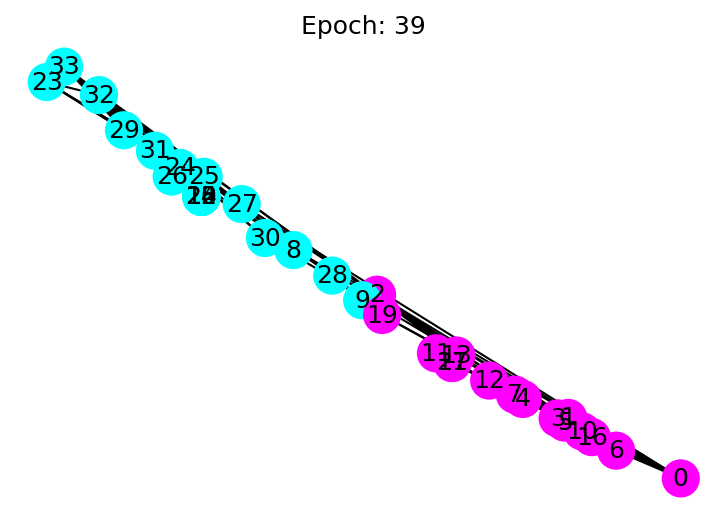

In [73]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
ax = fig.subplots()

draw(39)

In [74]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)